### Objective
This notebook runs the following steps:  
  - Read in the input data 
  - Do the train/test splits based on the ACF results 
  - Get the spearman correlation matrix for the training set 
  - Performs clustering (first on indices, second on spearman distance matrix)
  - Pull features for each subcluster and get the new train/test sets

In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.stats import spearmanr

from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

def get_region(id):
    """Given a residue index (integer), return a color associated with the region"""
    id = int(id)
    if id == 186:
        return "green"
    elif id < 75:
        return "gray"
    elif id >= 75 and id < 150:
        return "red"
    elif id >= 150 and id < 250 and id != 186:
        return "blue"
    elif id >= 250:
        return "purple"

def get_region_idx(id):
    """Given a residue index (integer), return an integer associated with the region"""
    id = int(id)
    if id == 186:
        return 2
    elif id < 75:
        return 0
    elif id >= 75 and id < 150:
        return 1
    elif id >= 150 and id < 250 and id != 186:
        return 3
    elif id >= 250:
        return 4
    
def generate_random_color():
    """UNUSED - Generate a random RGB color"""
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def inverse(df, last_col_labels=False):
    """
    Inverse the values in a dataframe

    Keyword arguments:
        df -- the dataframe
        last_col_labels -- if True -> last column will not be inversed
    
    Returns:
        df -- the inversed dataframe
    """
    if last_col_labels == True:
        return 1/df.iloc[:,:-1]
    elif last_col_labels == False:
        return 1/df
    
def add_labels(df, nSystem = 4, nFrames = 75000, join=False):
    """
    Add the label column.
    DANGER: I AM ASSUMING THAT WE HAVE FOUR PROTEINS WITH 75000 FRAMES EACH!

    Keyword arguments:
        df -- the dataframe
        join -- if True -> add the label column to the dataframe
               -- if False -> do not add the label column to the dataframe
    
    Returns:
        df3 -- the dataframe after adding the label column
        labels -- label Series
        frameNum -- frame number Series
    """
    
    # Frame numbers to add to the dataframe
    frames = np.arange(0,nFrames,1)
    
    labels = pd.DataFrame({'label': np.repeat(np.arange(nSystem), df.shape[0] // nSystem)})

    frameNum = pd.DataFrame({'frameNum': np.tile(frames, nSystem)})

    # If we want to add the columns
    if join:
        df = df.join([labels, frameNum])  # Join both at once
        df[['label', 'frameNum']] = df[['label', 'frameNum']].astype(int)  # Convert both columns

    labels = labels.astype(int)
    frameNum = frameNum.astype(int)
    return df, labels, frameNum

def return_SS_list(data, min, max, stride, plot, outname, metric="precomputed", linkage="average"):
    scores_SS_spearman = []
    
    for i in np.arange(min,max,stride):
        model = AgglomerativeClustering(n_clusters=i,metric=metric,linkage=linkage)
        y_predict = model.fit_predict(data)
        c = silhouette_score(data, y_predict)
        scores_SS_spearman.append(c)
        
    if plot == True:
        fig,ax = plt.subplots(figsize=(5,5),layout='tight')
        ax.plot(x, scores_SS_spearman)
        ax.axvline(np.argmax(scores_SS_spearman)*stride+min, color='red', linestyle='--')
        ax.text(max-min, np.max(scores_SS_spearman),f"{np.argmax(scores_SS_spearman[1:])*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
        
        ax.set_ylabel("Silhouette score")
        ax.set_xlabel("# of Clusters")
        plt.savefig(outname,dpi=400)
    return scores_SS_spearman

def plot_metrics_all(data, min, max, stride, outname, metric="precomputed", linkage="average"):
    fig,ax = plt.subplots(4,1, figsize=(8,12),layout='tight')
    model = AgglomerativeClustering(metric=metric,linkage=linkage)
    elbow = KElbowVisualizer(model, k=np.arange(min, max, stride), metric='distortion', locate_elbow=True,timings=False).fit(data)

    scores_DBI_spearman = []
    scores_CHS_spearman = []
    scores_SS_spearman = []
    
    x = np.arange(min,max,stride)
    for i in x:
        model = AgglomerativeClustering(n_clusters=i,metric=metric,linkage=linkage)
        y_predict = model.fit_predict(data)
        a = davies_bouldin_score(data, y_predict)
        b = calinski_harabasz_score(data, y_predict)
        c = silhouette_score(data, y_predict,metric=metric)
        scores_DBI_spearman.append(a)
        scores_CHS_spearman.append(b)
        scores_SS_spearman.append(c)

    ax[3].plot(x, elbow.k_scores_)
    ax[3].text(max-min, np.max(elbow.k_scores_),f"{elbow.elbow_value_} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[3].set_xticks(np.arange(min,max,stride*10))
    
    ax[0].plot(x, scores_SS_spearman)
    ax[0].axvline(np.argmax(scores_SS_spearman)*stride+min, color='red', linestyle='--')
    ax[0].text(max-min, np.max(scores_SS_spearman),f"{np.argmax(scores_SS_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[0].set_xticks(np.arange(min,max,stride*10))
    ax[1].plot(x, scores_CHS_spearman)
    ax[1].axvline(np.argmax(scores_CHS_spearman)*stride+min, color='red', linestyle='--')
    ax[1].text(max-min, np.max(scores_CHS_spearman),f"{np.argmax(scores_CHS_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[1].set_xticks(np.arange(min,max,stride*10))
    ax[2].plot(x, scores_DBI_spearman)
    ax[2].axvline(np.argmin(scores_DBI_spearman)*stride+min, color='red', linestyle='--')
    ax[2].text(max-min, np.max(scores_DBI_spearman),f"{np.argmin(scores_DBI_spearman)*stride+min} clusters",horizontalalignment='center',verticalalignment='bottom')
    ax[2].set_xticks(np.arange(min,max,stride*10))
    ax[0].set_ylabel("Silhouette score")
    ax[1].set_ylabel("Calinski Harabasz Score")
    ax[2].set_ylabel("Davies Bouldin score")
    ax[0].set_xlabel("# of Clusters")
    ax[1].set_xlabel("# of Clusters")
    ax[2].set_xlabel("# of Clusters")
    
    plt.savefig(outname,dpi=400)
    return scores_SS_spearman, scores_CHS_spearman, scores_DBI_spearman

def compute_subcluster_model(distance_matrix_spearman, dataset_cluster):
        store_data = [] # left labels
        subcluster_labels = dataset.columns[dataset_cluster] ## total subcluster labels
        score = 0 ## ideal SS score for clustering
        subcluster_dict = []  # labels for sub-sub cluster
        n_features = dataset_cluster.shape[0]
        if n_features >= 4:
            subcluster_spearman = distance_matrix_spearman[np.ix_(dataset_cluster,dataset_cluster)]
            SS = return_SS_list(subcluster_spearman, 2, n_features, 1, False, "output/spearman_ideal_6.jpg")
            ideal_clusters = np.argmax(SS) + 2
            subcluster_model = AgglomerativeClustering(n_clusters=ideal_clusters, 
                                                       compute_distances=True,metric="precomputed", linkage="average")
            subcluster_predict = subcluster_model.fit_predict(subcluster_spearman)
            for index in np.unique(subcluster_predict):
                subcluster_iter = subcluster_labels[subcluster_predict == index]  
                subcluster_dict.append(np.array(subcluster_iter))
                #choice = subcluster_iter[random.choice(range(len(subcluster_iter)))]
                choice = random.choice(subcluster_iter)
                store_data.append(choice)
            score = SS[ideal_clusters-2]
        elif n_features < 4 and n_features > 1:
            #ideal_clusters = 1
            score = 1
            subcluster_dict.append(np.array(subcluster_labels))
            #choice = subcluster_labels[random.choice(range(len(subcluster_labels)))]
            choice = random.choice(subcluster_labels)
            store_data.append(choice)
        elif n_features == 1:
            score = 1
            subcluster_dict.append(np.array(subcluster_labels))
            choice = subcluster_labels[0]
            store_data.append(choice)
        return subcluster_labels, store_data, score, subcluster_dict

def get_cluster(data, prediction, num):
    return data[prediction == num]


def idxlist_to_vmd(arr):
    selstr = "segname PROA and ("
    for i in arr:
        selstr += f"resid {i} or "
    selstr = selstr[:-4] + ")"
    return selstr

colorid = np.array(['dimgray', 'lightgray', 'saddlebrown', 'forestgreen', 'olive', 
                    'purple', 'orangered', 'orange', 'yellow', 'lawngreen', 'darkviolet', 
                    'royalblue', 'crimson', 'aqua', 'deepskyblue', 'blue', 'palevioletred', 
                    'khaki', 'deeppink', 'lightsalmon', 'violet', 'palegreen'])

marker_dict = {
    0: "X",
    1: "o",
    2: "D",
    3: "^",
    4: "s"
}

region_dict = {
    0: "N-TERM",
    1: "H1",
    2: "PAM",
    3: "H2",
    4: "H3"
}

color_dict = {
    0: "gray",
    1: "red",
    2: "green",
    3: "blue",
    4: "purple"
}

PAM_INDEX = 186

ModuleNotFoundError: No module named 'yellowbrick'

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Safe default font in Matplotlib


# Step 1  - Read data

We read in the complete dataset from step 05. Column names are of the following syntax: `WNTresid_WLSresid`

Call inverse() to get inverse contact distances.

Labels added:<br>
Wnt1A - 0 <br>
Wnt3A - 1 <br>
Wnt5a - 2 <br>
Wnt8a - 3 <br>

In [3]:
nFramesPerSystem = 75000
nSystems = 4

#contact = np.array(pd.read_csv(f"../05_combine/output/ML_input.csv")) 
#contact_df = pd.read_csv(f"../05_combine/output/ML_input.csv") #Just to get the columns
#contact = pd.DataFrame(contact, columns=contact_df.columns)
contact = pd.read_csv(f"../05_combine/output/ML_input.csv") 

In [4]:
contact.shape

(300000, 1153)

In [6]:
# Assuming df is your DataFrame
# Check if any column names end with ".1"
filtered_cols = [col for col in contact.columns if col.endswith(".1")]

print(filtered_cols)  # Output: ['value.1', 'data.1']

[]


In [7]:
## Jie: no need to inverse the raw distance!

#contact = inverse(contact, last_col_labels=False)
#print(f"After reading the data, we have {contact.shape[0]} samples and {contact.shape[1]} features.")


contact, contact_labels, frame_number = add_labels(contact, nSystem=nSystems, nFrames=nFramesPerSystem, join=True)
print(f"After adding labels to the data, we have {contact.shape[0]} samples and {contact.shape[1]} features.")

After adding labels to the data, we have 300000 samples and 1155 features.


In [21]:
contact

,45_76,49_76,56_171,56_172,59_171,60_171,99_75,101_43,101_44,101_45,...,45_75,108_74,103_73,105_49,131_98,180_459,183_181,183_182,label,frameNum
0,10.621099,10.634332,9.744870,9.957552,10.489298,11.105033,11.069887,13.282561,10.889764,10.746555,...,9.126897,13.976026,13.793037,13.280609,10.591424,15.618086,13.860012,13.849919,0,0
1,10.577792,11.450068,10.224063,10.639061,11.306942,11.946851,11.434151,12.998787,10.596194,11.036841,...,9.175077,13.591064,13.579180,13.030798,11.367104,16.701450,13.963057,13.546408,0,1
2,10.181662,10.742149,9.640066,9.485501,10.790931,12.004856,11.421351,13.282635,10.426994,10.630170,...,9.096071,13.637458,14.574110,13.472633,11.572993,15.088956,14.109032,14.294400,0,2
3,10.604144,11.399232,10.287755,10.186411,11.140853,11.929076,11.592047,13.952415,11.389983,11.238181,...,9.169610,13.638085,14.979506,13.613780,10.649776,15.890335,14.056595,14.221059,0,3
4,11.034605,11.396881,8.977599,10.021485,10.488602,11.457756,11.549748,13.802044,11.056829,10.609860,...,9.230783,14.144676,14.283993,13.149389,11.530153,15.556634,14.420149,14.231995,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,12.814123,12.110405,12.656578,12.755559,13.366348,13.006972,11.770701,13.243452,10.846751,10.579851,...,13.215437,12.671959,12.753555,12.663667,14.332894,16.788841,14.700027,14.356225,3,74995
299996,12.226279,12.316513,12.621320,13.123354,14.015167,14.635726,11.673959,13.069013,10.597171,10.108086,...,12.775546,12.500253,12.635729,12.494875,13.999336,17.759033,14.435913,14.244097,3,74996
299997,12.308189,12.235721,11.948527,12.753634,12.635560,13.184617,11.783118,12.533669,10.371541,10.057330,...,12.958007,13.618883,13.177293,12.479662,13.284402,16.885484,14.070871,13.879761,3,74997
299998,12.756529,12.604131,12.262629,12.946589,13.603724,13.271378,11.534217,13.043450,10.790129,10.630162,...,13.236657,12.897412,13.017492,12.941740,13.909177,17.734606,14.607776,14.471466,3,74998


# Step 2 - ACF Train/Test Split

We will split the data into a train and test set based on the tau value calculated from 06_acf/corr.ipynb.

The test set will contain the frames ranging from 0 - tau.
The train set will contain the frames ranging from 2*tau - nFramesPerSystem.


In [9]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()

# taus = [WNT1 Tau, WNT3a Tau, WNT5a Tau, WNT8a Tau]
# Extracted from 06_acf/
taus = [15478, 15444, 17170, 18160]

# For each system, 
for i in range(len(taus)):
    test_set = pd.concat([test_set, contact.loc[(nFramesPerSystem*i):(nFramesPerSystem*i) + taus[i] -1]])
    train_set = pd.concat([train_set, contact.loc[(nFramesPerSystem*i)+(2*taus[i]):(nFramesPerSystem*(i+1))- 1]])

dataset = train_set.iloc[:,:-2] # Dataset without the frame number and system number
print(f"The training data set has {train_set.shape[0]} samples. The test data set has {test_set.shape[0]} samples.")

The training data set has 167496 samples. The test data set has 66252 samples.


# Step 3 -  Spearman Correlation

The spearman correlation matrix is defined using scipy.stats.spearmanr(). We ensure that the matrix is symmetric and define the diagonal as 1 (integer). This is already the case, but sometimes scipy will read 0.9999... instead of 1.

In [11]:
corr = spearmanr(dataset).correlation
corr = (corr + corr.T)/2
np.fill_diagonal(corr,1)

# We convert the correlation matrix to a distance matrix before performing clustering.
distance_matrix_spearman = 1 - np.abs(corr)

In [12]:
corr.shape

(1153, 1153)

## Step 4A - Cluster on Regions

In [13]:
# These are the WNT8a labels from BEFORE we merge down to contacts occurring in all systems
# Load WNT8a contact labels from file
wnt8a_contact_distances_idx = np.loadtxt("../04_map/output/WNT8a_threshhold12_labels.txt", dtype=str)

# split labels into two integer arrays
wnt_idx = np.array([list(map(int, label.split("_"))) for label in wnt8a_contact_distances_idx])

# Convert back to formatted strings
wnt8a_contact_distances_str = np.array([f"{wnt}_{wls}" for wnt, wls in wnt_idx])


In [14]:
wnt_idx

array([[ 45,  76],
       [ 49,  76],
       [ 56, 171],
       ...,
       [197, 218],
       [177, 164],
       [183, 182]])

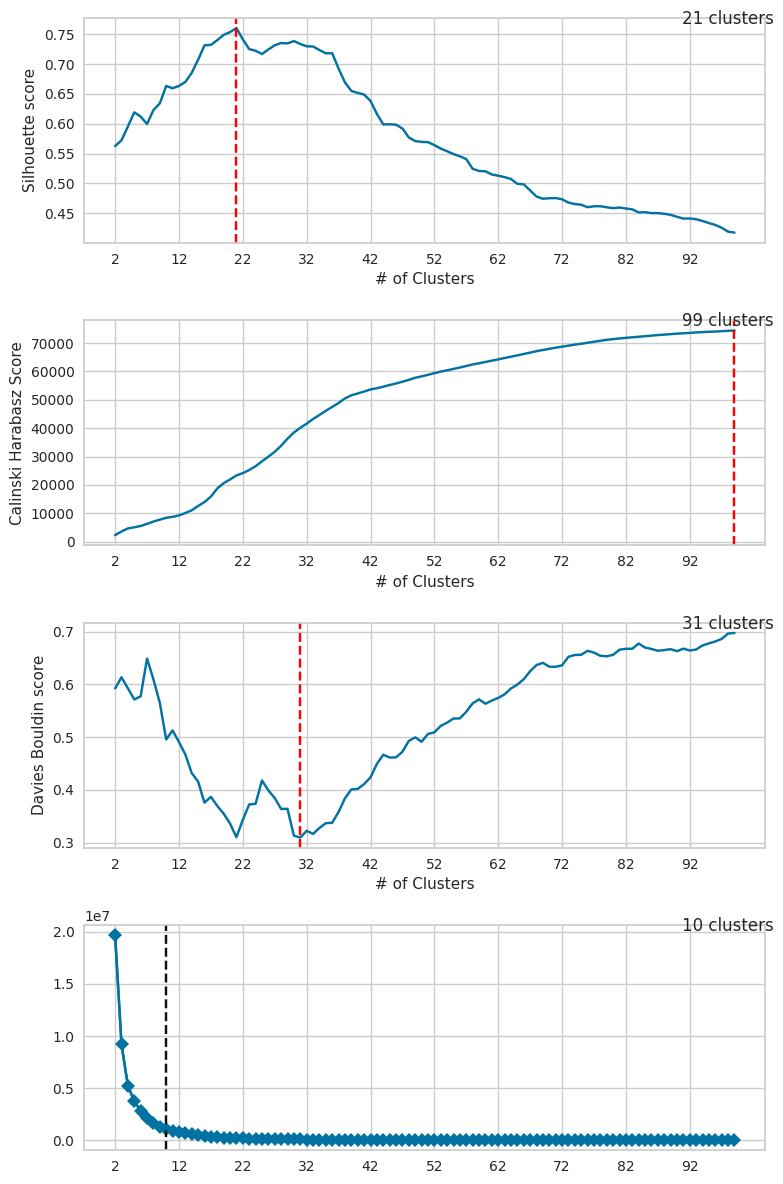

In [27]:
# Plot all of the metrics - we will use the SS score
SS, CHS, DBS =  plot_metrics_all(wnt_idx, 2, 100, 1, "plots/all_clustering_metrics_stage1.jpg",metric="euclidean", linkage="ward")

In [28]:
len(SS)

98

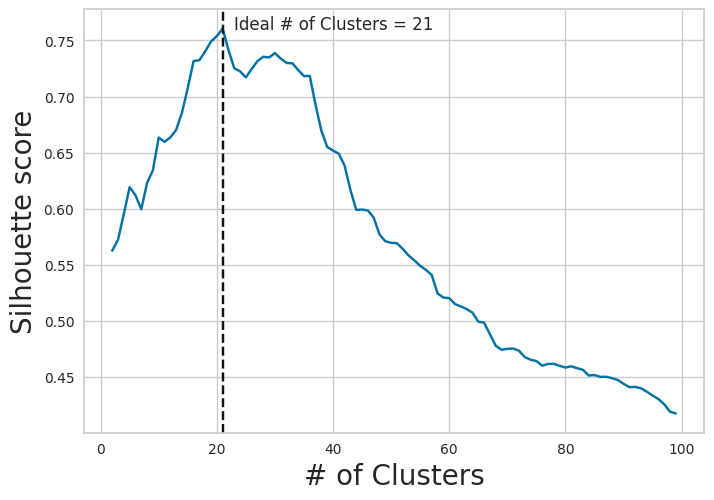

In [29]:
plt.plot(np.arange(2,100,1),SS)
plt.axvline(x=21,linestyle='--',color='k')
plt.text(23,0.76, f"Ideal # of Clusters = 21")
plt.xlabel("# of Clusters", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.savefig(f"plots/silhouette_score_stage1.jpg", dpi=400)

In [21]:
# Agglo clustering based on SS Score

clustering = AgglomerativeClustering(n_clusters=21, compute_distances=True)
wnt_predict = clustering.fit_predict(wnt_idx)

# For each datapoint, give it a color and a region
#cluster_colors = np.array([colorid[wnt_predict[i]] for i in range(len(wnt_predict))]) # Select colors per cluster
cluster_colors = colorid[wnt_predict]  # # Select colors per cluster (21 total)

#region_colors = np.array([get_region(int(dataset.columns[i].split("_")[0])) for i in range(len(dataset.columns))]) # Region per cluster
#region_colors = np.array([get_region(int(col.split("_")[0])) for col in dataset.columns]) # color per region (5 total)

markers = []  ## markers of the region per cluster
region = []  ## names of the region
region_colors = [] ## colors of the region

# Assign the regions and the markers - for visualization
for i in range(clustering.n_clusters_):
    #current_cluster_idx = np.unique(np.array([idx[0] for idx in wnt_idx[np.where(wnt_predict == i)]]).astype(int))
    current_cluster_idx = np.unique(wnt_idx[wnt_predict == i, 0]).astype(int)  # Extract first column directly
    if len(current_cluster_idx) != 0:
        min_idx = np.min(current_cluster_idx)  # min wnt indx
        region_idx = get_region_idx(min_idx)  # region indx based on min idx
        
        if PAM_INDEX not in current_cluster_idx:
            region.append(region_dict[region_idx])
            region_colors.append(color_dict[region_idx])
            markers.append(marker_dict[region_idx])
        else:
            pam_region_idx = get_region_idx(PAM_INDEX)
            region.append(region_dict[pam_region_idx])
            region_colors.append(color_dict[pam_region_idx])
            markers.append(marker_dict[pam_region_idx])
    else:
        markers.append("x")
        region.append("x")
        region_colors.append("x")
        
train_set_clusters = np.zeros(len(dataset.columns))
for i,col in enumerate(dataset.columns):
    train_set_clusters[i] = wnt_predict[wnt8a_contact_distances_str==col]

### Plot shape per cluster

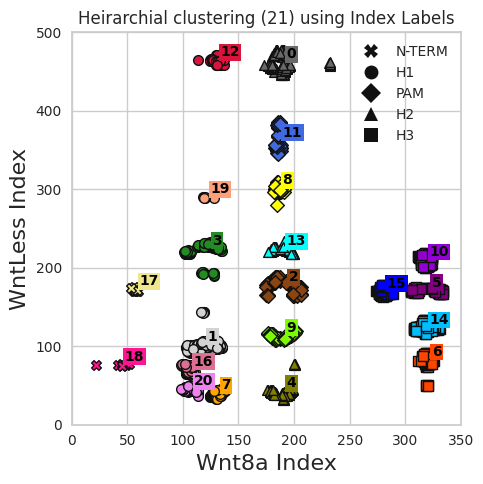

In [35]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(5,5))

for i in range(clustering.n_clusters_):
    ax1.scatter(wnt_idx[wnt_predict == i, 0], 
                wnt_idx[wnt_predict == i, 1],
                color=colorid[i], marker=markers[i], alpha=1, edgecolors='k', linewidths=1)
    ax1.annotate(f"{i}", (np.average(wnt_idx[wnt_predict == i, 0]), 
                          np.average(wnt_idx[wnt_predict == i, 1])), fontsize=10, 
                         fontweight=1000,color='black', xycoords='data',  xytext=(3,3), 
                         textcoords='offset points',bbox=dict(boxstyle="square,pad=0.1", 
                                                                fc=colorid[i], ec='black', lw=0))
ax1.set_xlim(0,350)
ax1.set_ylim(0,500)
ax1.set_title(f"Heirarchial clustering (21) using Index Labels")
ax1.set_xlabel("Wnt8a Index", fontsize=16)
ax1.set_ylabel("WntLess Index", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], 
                        markersize=10, markeredgecolor='r', markerfacecolor='k', linestyle='') 
                for i in range(len(region_dict))]

handles.extend(pts)
plt.legend(handles=handles)
plt.savefig("plots/clusterbyindex_stage1.png",dpi=400)


### Plot shape per data point

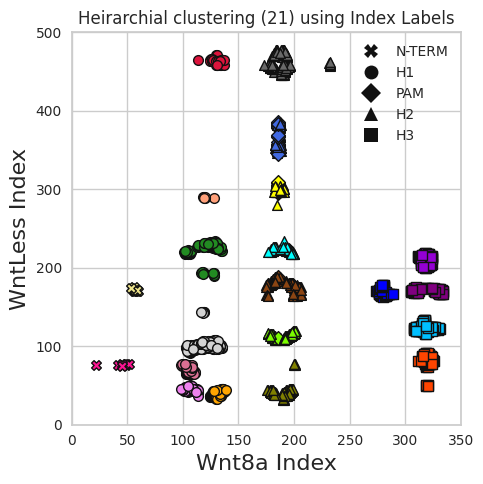

In [36]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(5,5))

for i,cluster_idx in enumerate(wnt_predict):
    region_idx = get_region_idx(wnt_idx[i, 0])
    
    ax1.scatter(wnt_idx[i, 0], 
                wnt_idx[i, 1],
                color=colorid[cluster_idx], marker=marker_dict[region_idx], alpha=1, edgecolors='k', linewidths=1)
#    ax1.annotate(f"{i}", (np.average(wnt_idx[wnt_predict == i, 0]), 
#                          np.average(wnt_idx[wnt_predict == i, 1])), fontsize=10, 
#                         fontweight=1000,color='black', xycoords='data',  xytext=(3,3), 
#                         textcoords='offset points',bbox=dict(boxstyle="square,pad=0.1", 
#                                                                fc=colorid[i], ec='black', lw=0))

ax1.set_xlim(0,350)
ax1.set_ylim(0,500)
ax1.set_title(f"Heirarchial clustering (21) using Index Labels")
ax1.set_xlabel("Wnt8a Index", fontsize=16)
ax1.set_ylabel("WntLess Index", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], 
                        markersize=10, markeredgecolor='r', markerfacecolor='k', linestyle='') 
                for i in range(len(region_dict))]

handles.extend(pts)
plt.legend(handles=handles)
#plt.savefig("plots/clusterbyindex_stage1.png",dpi=400)


In [16]:
# We want to see what the tSNE plot looks like for the  features kept
# keeper = those  features we kept
# Convert dataset columns to a set for faster lookups
dataset_columns_set = set(dataset.columns)

# Use list comprehension and NumPy for fast filtering
keeper = np.array([i for i, val in enumerate(wnt8a_contact_distances_idx) if val in dataset_columns_set])


In [20]:
keeper.shape

(1153,)

In [40]:
# Load original distance matrix
wnt8a_contact_distances = np.load("../03_finalize_dataset/output/WNT8a_threshhold12_matrix.npy")

# Compute Spearman correlation once
corr = spearmanr(wnt8a_contact_distances).correlation

# Ensure symmetry & set diagonal to 1
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Compute Spearman distance matrix before merging (1924 features)
distance_matrix_spearman_beforemerge = 1 - np.abs(corr)

# Compute Spearman distance matrix after merging (1153 features) using precomputed corr
distance_matrix_spearman_aftermerge = 1 - np.abs(corr[np.ix_(keeper, keeper)])


In [41]:
distance_matrix_spearman_beforemerge.shape

(1924, 1924)

In [22]:
# Keep only the predictions for the features after merging
wnt_predict_new = wnt_predict[keeper]

In [25]:
np.unique(wnt_predict_new)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20])

In [43]:
wnt8a_contact_distances.shape

(75000, 1924)

## Jie: add precomputed, since we are not inputing raw distance matrix

In [44]:
# tSNE before and after the merge
tsne = TSNE(n_components=2,metric='precomputed',init='random')
tsne_results_beforemerge = tsne.fit_transform(distance_matrix_spearman_beforemerge)

tsne = TSNE(n_components=2,metric='precomputed',init='random')
tsne_results_aftermerge = tsne.fit_transform(distance_matrix_spearman_aftermerge)

In [45]:
tsne_results_aftermerge.shape

(1153, 2)

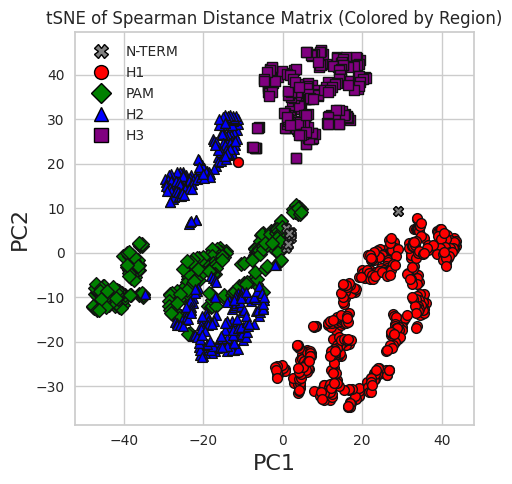

In [47]:
# Create figure
fig, ax1 = plt.subplots(figsize=(5, 5))

# Scatter plot for each cluster
for i in range(clustering.n_clusters_):
    cluster_mask = (wnt_predict_new == i)  # Boolean mask for the cluster

    ax1.scatter(
        tsne_results_aftermerge[cluster_mask, 0],  # PC1 values
        tsne_results_aftermerge[cluster_mask, 1],  # PC2 values
        color=region_colors[i], 
        marker=markers[i], 
        alpha=1, 
        edgecolors='k', 
        linewidths=1
    )

# Axis labels and title
ax1.set_title("tSNE of Spearman Distance Matrix (Colored by Region)")
ax1.set_xlabel("PC1", fontsize=16)
ax1.set_ylabel("PC2", fontsize=16)
plt.tight_layout()

# Create manual legend symbols
legend_elements = [
    Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], 
           markersize=10, markeredgecolor='black', markeredgewidth=1,
           markerfacecolor=color_dict[i], linestyle='')
    for i in range(len(region_dict))
]

# Add legend
ax1.legend(handles=legend_elements, loc="best")

# Save figure
plt.savefig("plots/clusterbyindex_stage1.png", dpi=400)
plt.show()


In [48]:
cluster_colors = np.array([colorid[wnt_predict_new[i]] for i in range(len(wnt_predict_new))]) # Select colors per cluster
region_colors = np.array([get_region(int(dataset.columns[i].split("_")[0])) for i in range(len(dataset.columns))]) # Region per cluster

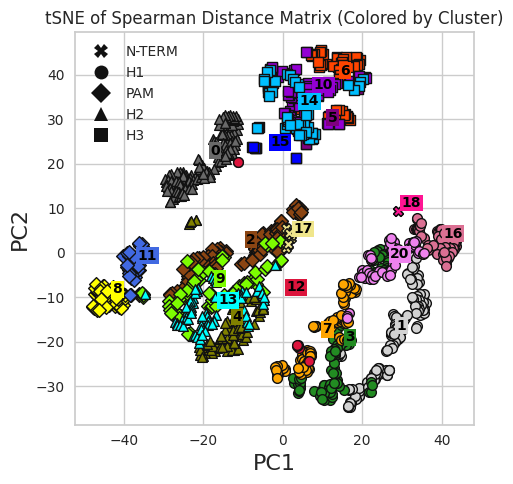

In [49]:
fig,ax1=plt.subplots(figsize=(5,5))
for i in range(clustering.n_clusters_):
    ax1.scatter(tsne_results_aftermerge[np.where(wnt_predict_new == i),0].reshape(-1), 
                tsne_results_aftermerge[np.where(wnt_predict_new == i),1].reshape(-1), 
                color=colorid[i], marker=markers[i], alpha=1, edgecolors='k', linewidths=1)
    ax1.annotate(f"{i}", (np.average(tsne_results_aftermerge[np.where(wnt_predict_new == i),0]), 
                          np.average(tsne_results_aftermerge[np.where(wnt_predict_new == i),1])), 
                 fontsize=10, fontweight=1000,color='black', xycoords='data',  xytext=(3,3), 
                 textcoords='offset points',bbox=dict(boxstyle="square,pad=0.1", fc=colorid[i], ec='black', lw=0))
    
ax1.set_title(f"tSNE of Spearman Distance Matrix (Colored by Cluster)")
ax1.set_xlabel("PC1", fontsize=16)
ax1.set_ylabel("PC2", fontsize=16)
plt.tight_layout()

# create manual symbols for legend
handles, labels = plt.gca().get_legend_handles_labels()
pts = [Line2D([0], [0], label=region_dict[i], marker=marker_dict[i], markersize=10, markeredgecolor='r', markerfacecolor='k', linestyle='') for i in range(5)]
handles.extend(pts)
plt.legend(handles=handles)
plt.savefig("plots/clusterbyindex_stage2.png",dpi=400)


## Step 4B - Subclustering



In [53]:
# There are 21 clusters
subcluster_contact_labels = []

In [54]:
# Set the random seed to FREEZE results
random.seed(0)

# New dataframe that we will use to store the info from the second level of clustering
df = pd.DataFrame(columns=['clusteridx','nPoints','nSubClusters','SS','selectedSubclusterPoints','ALLsubclusterPoints'])

# For each of the clusters from lvl 1
for i in range(clustering.n_clusters_):
    
    ## get all of the points that are in the current cluster (i)
    #current_wnt_cluster = get_cluster(wnt_idx, wnt_predict, i)
    
    # get all of the indeces of the points that are in the current cluster (i)
    current_wnt_cluster_labels = get_cluster(wnt8a_contact_distances_idx, wnt_predict, i)
    
    # For each of the points in the cluster, find that column in the original dataset
    # We need to map the clusters back to the feature idx
    #dataset_cluster = np.array([np.where(dataset.columns == curr) for curr in current_wnt_cluster_labels if curr in dataset.columns]).flatten()
    dataset_cluster = np.array([dataset.columns.get_loc(curr) 
                            for curr in current_wnt_cluster_labels if curr in dataset.columns])
    # Take all of the points in the subcluster -> dataset_cluster
    # Use that to parse the spearman distance matrix and determine the optimal # of subclusters
    if dataset_cluster.size <=0:  # skip cases where non of the label in the cluster are in the final ML input features
        continue
        
    subcluster_labels, store_data, ss_score, ss_dict = compute_subcluster_model(distance_matrix_spearman, dataset_cluster)

    # store in the dataframe
#    df.loc[-1] = [i, len(subcluster_labels), len(store_data), ss_score, store_data, ss_dict]
#    df.index = df.index + 1

    new_row = pd.DataFrame([{
    'clusteridx': i, 
    'nPoints': len(subcluster_labels), 
    'nSubClusters': len(store_data), 
    'SS': ss_score, 
    'selectedSubclusterPoints': store_data, 
    'ALLsubclusterPoints': ss_dict
}])

    df = pd.concat([df, new_row], ignore_index=True)
    subcluster_contact_labels.append(store_data)
df.to_pickle("output/clusterbyindex_df.pkl")

In [55]:
#subcluster_contact_labels_flattened = np.array([label for subcluster in subcluster_contact_labels for label in subcluster], dtype=str)
subcluster_contact_labels_flattened = np.concatenate(subcluster_contact_labels).astype(str)

subcluster_contact_label_regions = np.array([get_region(int(i.split("_")[0])) for i in subcluster_contact_labels_flattened], dtype=str)


# Save each region's labels to a file
for color in ['red', 'green', 'blue', 'purple', 'gray']:
    labels_in_color = subcluster_contact_labels_flattened[subcluster_contact_label_regions == color]
    np.savetxt(f"output/cluster_region_{color}.txt", labels_in_color, fmt='%s')

In [56]:
cols = [dataset.columns.get_loc(i) for i in subcluster_contact_labels_flattened if i in dataset.columns]
cols.extend([-2, -1]) # also keep the last two columns


# Select the columns
train_set_subcluster = train_set.iloc[:, cols]
test_set_subcluster  = test_set.iloc[:, cols]


In [79]:
train_set_ordered = train_set_subcluster.sort_values(by=['frameNum', 'label'], ascending=True)
print(train_set_ordered.shape)
train_set_ordered.to_csv(f"model/X_train_dt10_4.csv", index=False)

(167496, 203)


In [80]:
test_set_ordered = test_set_subcluster.sort_values(by=['frameNum', 'label'], ascending=True)
test_set_ordered.to_csv(f"model/X_test_dt10_4.csv", index=False)

## Illustrating the clusters

In [2]:
df=pd.read_pickle("output/clusterbyindex_df.pkl")

In [3]:
df

,index,clusteridx,nPoints,nSubClusters,SS,selectedSubclusterPoints,ALLsubclusterPoints
0,0,0,135,2,0.482629,"[192_456, 194_468]","[[178_457, 180_454, 180_456, 180_457, 181_454,..."
1,1,1,114,43,0.317527,"[129_104, 109_98, 131_98, 130_106, 104_94, 128...","[[126_104, 127_104, 127_105, 128_104, 128_105,..."
2,2,2,97,20,0.303685,"[206_172, 202_171, 199_165, 181_181, 178_180, ...","[[202_175, 203_176, 206_175, 205_175, 204_176,..."
3,3,3,87,14,0.258341,"[130_232, 126_228, 126_227, 106_222, 132_226, ...","[[130_228, 130_231, 130_232], [126_228, 127_22..."
4,4,4,76,3,0.236376,"[191_42, 193_44, 178_44]","[[181_40, 182_40, 183_39, 183_40, 183_41, 184_..."
5,5,5,3,1,1.000000,[311_170],"[[310_170, 311_170, 319_174]]"
6,6,6,58,36,0.243869,"[317_81, 317_90, 319_91, 320_90, 323_86, 319_8...","[[316_81, 317_81], [317_89, 317_90], [319_91, ..."
7,7,7,79,2,0.294738,"[126_36, 127_41]","[[124_35, 124_36, 124_37, 125_35, 125_36, 125_..."
8,8,8,49,4,0.365803,"[185_308, 191_300, 185_297, 186_303]","[[183_300, 183_301, 184_300, 184_301, 184_302,..."
9,9,9,69,6,0.337765,"[183_111, 180_114, 195_115, 181_112, 193_112, ...","[[182_111, 183_108, 183_109, 183_110, 183_111,..."


In [4]:
features_rep=[]
features_cluster=[]
for index, row in df.iterrows():
    features_rep.extend(row['selectedSubclusterPoints'])
    features_cluster.extend(row['ALLsubclusterPoints'])


In [5]:
mapping = dict(zip(features_rep,features_cluster))

In [25]:
contact = '135_98'
mapping.get(contact)

array(['135_98'], dtype=object)

In [15]:
mapping

{'192_456': array(['178_457', '180_454', '180_456', '180_457', '181_454', '182_453',
        '182_454', '184_450', '188_450', '188_454', '189_447', '189_449',
        '189_450', '189_451', '189_452', '189_453', '189_454', '189_455',
        '190_446', '190_447', '190_448', '190_449', '190_450', '190_451',
        '190_452', '190_453', '190_454', '190_455', '190_456', '191_446',
        '191_447', '191_449', '191_450', '191_451', '191_452', '191_453',
        '191_454', '191_455', '191_456', '191_457', '192_450', '192_453',
        '192_454', '192_455', '192_456', '192_457', '193_453', '193_454',
        '193_456', '193_457', '193_458', '194_453', '194_454', '194_456',
        '194_457', '194_458', '194_459', '195_457', '179_457', '184_453',
        '192_458', '196_457', '178_454', '178_456', '180_453', '192_451',
        '194_455', '181_457', '182_457', '193_459', '195_456', '195_458',
        '195_459', '179_456', '177_457', '178_458', '191_458', '190_458',
        '179_458', '180_458